<div align="center">
<h1><img width="30" src="https://madewithml.com/static/images/rounded_logo.png">&nbsp;<a href="https://madewithml.com/">Made With ML</a></h1>
Applied ML · MLOps · Production
<br>
Join 30K+ developers in learning how to responsibly <a href="https://madewithml.com/about/">deliver value</a> with ML.
    <br>
</div>

<br>

<div align="center">
    <a target="_blank" href="https://madewithml.com"><img src="https://img.shields.io/badge/Subscribe-40K-brightgreen"></a>&nbsp;
    <a target="_blank" href="https://github.com/GokuMohandas/MadeWithML"><img src="https://img.shields.io/github/stars/GokuMohandas/MadeWithML.svg?style=social&label=Star"></a>&nbsp;
    <a target="_blank" href="https://www.linkedin.com/in/goku"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
    <a target="_blank" href="https://twitter.com/GokuMohandas"><img src="https://img.shields.io/twitter/follow/GokuMohandas.svg?label=Follow&style=social"></a>
    <br>
    🔥&nbsp; Among the <a href="https://github.com/GokuMohandas/MadeWithML" target="_blank">top MLOps</a> repositories on GitHub
</div>

<br>
<hr>


# Monitoring ML

This notebook complements the [monitoring ML lesson](https://madewithml.com/courses/mlops/testing/) where we learn how to monitor ML systems to identify and mitigate sources of drift to prevent model performance decay. All the concepts mentioned here are covered in much more detail and tied to software engineering best practices for building ML systems. So be sure to check out the [lesson](https://madewithml.com/courses/mlops/monitoring/) if you haven't already.

<div align="left">
<a target="_blank" href="https://madewithml.com/courses/mlops/monitoring/"><img src="https://img.shields.io/badge/📖 Read-lesson-9cf"></a>&nbsp;
<a href="https://github.com/GokuMohandas/monitoring-ml/blob/main/monitoring.ipynb" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/GokuMohandas/monitoring-ml/blob/main/monitoring.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

# Set up

> We suggest you execute this notebook on [Google colab](https://colab.research.google.com/github/GokuMohandas/monitoring-ml/blob/main/monitoring.ipynb) since we leverage many of the preinstalled packages, as well as the free GPU. However, as always, we can also run this locally but we'll have to manually install any missing packages.

In [1]:
# High quality plots
%config InlineBackend.figure_format = "svg"

In [ ]:
# Install Alibi (Seldon)
!pip install alibi-detect==0.9.1 -q

# Performance

Illustrating the need to monitor metrics at various window sizes to catch performance degradation as soon as possible. Here we're monitoring an overall metric but we can do the same for slices of data, individual classes, etc. For example, if we monitor the performance on a specific tag, we may be able to quickly catch new algorithms that were released for that tag (ex. new transformer architecture).

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme()

In [4]:
# Generate data
hourly_f1 = list(np.random.randint(low=94, high=98, size=24*20)) + \
            list(np.random.randint(low=92, high=96, size=24*5)) + \
            list(np.random.randint(low=88, high=96, size=24*5)) + \
            list(np.random.randint(low=86, high=92, size=24*5))

In [5]:
# Cumulative f1
cumulative_f1 = [np.mean(hourly_f1[:n]) for n in range(1, len(hourly_f1)+1)]
print (f"Average cumulative f1 on the last day: {np.mean(cumulative_f1[-24:]):.1f}")

Average cumulative f1 on the last day: 93.7


In [6]:
# Sliding f1
window_size = 24
sliding_f1 = np.convolve(hourly_f1, np.ones(window_size)/window_size, mode="valid")
print (f"Average sliding f1 on the last day: {np.mean(sliding_f1[-24:]):.1f}")

Average sliding f1 on the last day: 88.5


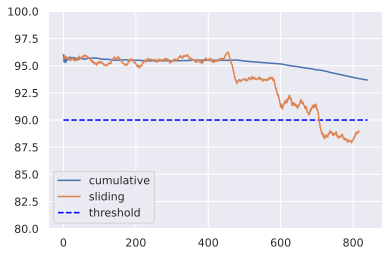

In [7]:
plt.ylim([80, 100])
plt.hlines(y=90, xmin=0, xmax=len(hourly_f1), colors="blue", linestyles="dashed", label="threshold")
plt.plot(cumulative_f1, label="cumulative")
plt.plot(sliding_f1, label="sliding")
plt.legend()

In [8]:
# Generate data
gradual = list(np.random.uniform(96, 98, 20)) + \
          list(np.random.uniform(94, 96, 20)) + \
          list(np.random.uniform(92, 94, 20)) + \
          list(np.random.uniform(90, 92, 20))
abrupt =  list(np.random.uniform(92, 94, 20)) + \
          list(np.random.uniform(90, 92, 20)) + \
          list(np.random.uniform(78, 80, 40))
periodic = list(np.random.uniform(87, 89, 15)) + \
           list(np.random.uniform(81, 85, 25)) + \
           list(np.random.uniform(87, 89, 15)) + \
           list(np.random.uniform(81, 85, 25))

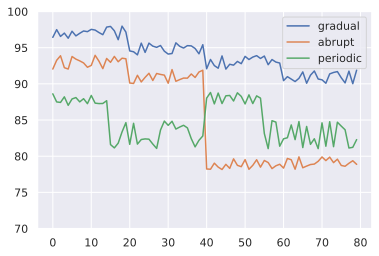

In [9]:
plt.ylim([70, 100])
plt.plot(gradual, label="gradual")
plt.plot(abrupt, label="abrupt")
plt.plot(periodic, label="periodic")
plt.legend()

# Data

In [ ]:
!pip install great-expectations==0.15.7 -q

In [11]:
import great_expectations as ge
import json
import pandas as pd
from urllib.request import urlopen

In [12]:
# Load labeled projects
projects = pd.read_csv("https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.csv")
tags = pd.read_csv("https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.csv")
df = ge.dataset.PandasDataset(pd.merge(projects, tags, on="id"))
df["text"] = df.title + " " + df.description
df.drop(["title", "description"], axis=1, inplace=True)
df.head(5)

,id,created_on,tag,text
0,6,2020-02-20 06:43:18,computer-vision,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,computer-vision,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,graph-learning,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,reinforcement-learning,Awesome Monte Carlo Tree Search A curated list...
4,19,2020-03-03 13:54:31,graph-learning,Diffusion to Vector Reference implementation o...


# Expectations

Rule-based expectations that must pass.

In [13]:
# Simulated production data
prod_df = ge.dataset.PandasDataset([{"text": "hello"}, {"text": 0}, {"text": "world"}])

In [14]:
# Expectation suite
df.expect_column_values_to_not_be_null(column="text")
df.expect_column_values_to_be_of_type(column="text", type_="str")
expectation_suite = df.get_expectation_suite()

In [15]:
# Validate reference data
df.validate(expectation_suite=expectation_suite, only_return_failures=True)["statistics"]

{'evaluated_expectations': 2,
 'success_percent': 100.0,
 'successful_expectations': 2,
 'unsuccessful_expectations': 0}

In [16]:
# Validate production data
prod_df.validate(expectation_suite=expectation_suite, only_return_failures=True)["statistics"]

{'evaluated_expectations': 2,
 'success_percent': 50.0,
 'successful_expectations': 1,
 'unsuccessful_expectations': 1}

# Univariate

Drift detection on univariate data.

### Kolmogorov-Smirnov (KS) test

KS test for detecting data drift on input sequence length. We can monitor aspects of our data that aren't necessarily inputs to the model (ex. length of input text).

In [ ]:
from alibi_detect.cd import KSDrift

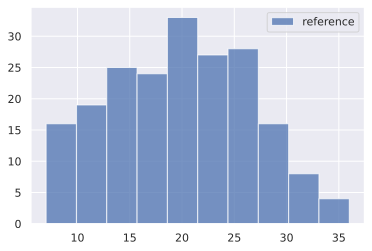

In [ ]:
# Reference
df["num_tokens"] = df.text.apply(lambda x: len(x.split(" ")))
ref = df["num_tokens"][0:200].to_numpy()
plt.hist(ref, alpha=0.75, label="reference")
plt.legend()
plt.show()

In [ ]:
# Initialize drift detector
length_drift_detector = KSDrift(ref, p_val=0.01)

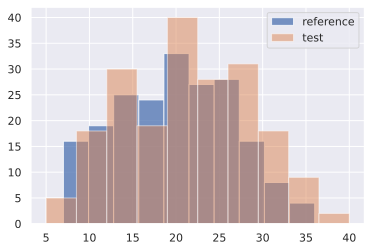

In [ ]:
# No drift
no_drift = df["num_tokens"][200:400].to_numpy()
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(no_drift, alpha=0.5, label="test")
plt.legend()
plt.show()

In [ ]:
length_drift_detector.predict(no_drift, return_p_val=True, return_distance=True)

{'data': {'distance': array([0.09], dtype=float32),
  'is_drift': 0,
  'p_val': array([0.3927307], dtype=float32),
  'threshold': 0.01},
 'meta': {'data_type': None,
  'detector_type': 'offline',
  'name': 'KSDrift',
  'version': '0.9.1'}}

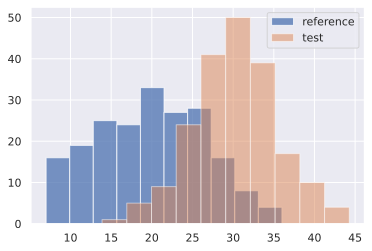

In [ ]:
# Drift
drift = np.random.normal(30, 5, len(ref))
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(drift, alpha=0.5, label="test")
plt.legend()
plt.show()

In [ ]:
length_drift_detector.predict(drift, return_p_val=True, return_distance=True)

{'data': {'distance': array([0.63], dtype=float32),
  'is_drift': 1,
  'p_val': array([6.7101775e-35], dtype=float32),
  'threshold': 0.01},
 'meta': {'data_type': None,
  'detector_type': 'offline',
  'name': 'KSDrift',
  'version': '0.9.1'}}

### Chi-squared test

Detecting drift on categorical variables (can be used for data or target drift).

In [ ]:
from alibi_detect.cd import ChiSquareDrift

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


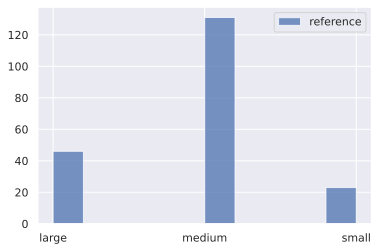

In [ ]:
# Reference
df.token_count = df.num_tokens.apply(lambda x: "small" if x <= 10 else ("medium" if x <=25 else "large"))
ref = df.token_count[0:200].to_numpy()
plt.hist(ref, alpha=0.75, label="reference")
plt.legend()

In [ ]:
# Initialize drift detector
target_drift_detector = ChiSquareDrift(ref, p_val=0.01)

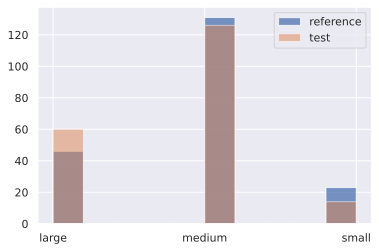

In [ ]:
# No drift
no_drift = df.token_count[200:400].to_numpy()
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(no_drift, alpha=0.5, label="test")
plt.legend()
plt.show()

In [ ]:
target_drift_detector.predict(no_drift, return_p_val=True, return_distance=True)

{'data': {'distance': array([4.135522], dtype=float32),
  'is_drift': 0,
  'p_val': array([0.12646863], dtype=float32),
  'threshold': 0.01},
 'meta': {'data_type': None,
  'detector_type': 'offline',
  'name': 'ChiSquareDrift',
  'version': '0.9.1'}}

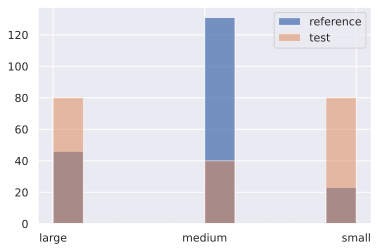

In [ ]:
# Drift
drift = np.array(["small"]*80 + ["medium"]*40 + ["large"]*80)
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(drift, alpha=0.5, label="test")
plt.legend()
plt.show()

In [ ]:
target_drift_detector.predict(drift, return_p_val=True, return_distance=True)

{'data': {'distance': array([89.145195], dtype=float32),
  'is_drift': 1,
  'p_val': array([4.389017e-20], dtype=float32),
  'threshold': 0.01},
 'meta': {'data_type': None,
  'detector_type': 'offline',
  'name': 'ChiSquareDrift',
  'version': '0.9.1'}}

# Multivariate

Drfit detection on multivariate data.

As we can see, measuring drift is fairly straightforward for univariate data but difficult for multivariate data. We'll summarize the reduce and measure approach outlined in the following paper: [Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/abs/1810.11953).

<div>
    <img width="700" src="https://madewithml.com/static/images/mlops/monitoring/failing_loudly.png">
</div>

In [ ]:
# Reference
ref = df.text[0:200].to_list()

### Embeddings

We vectorized our text using tf-idf (to keep modeling simple), which has high dimensionality and is not semantically rich in context. However, typically with text, word/char embeddings are used. So to illustrate what drift detection on multivariate data would look like, let's represent our text using pretrained embeddings.

> Be sure to refer to our [embeddings](https://madewithml.com/courses/foundations/embeddings) and [transformers](https://madewithml.com/courses/foundations/transformers) lessons to learn more about these topics. But note that detecting drift on multivariate text embeddings is still quite difficult so it's typically more common to use these methods applied to tabular features or images.

We'll start by loading the tokenizer from a pretrained model.

In [ ]:
from transformers import AutoTokenizer

In [ ]:
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
vocab_size = len(tokenizer)
print (vocab_size)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

31090


In [ ]:
# Tokenize inputs
encoded_input = tokenizer(df.text.tolist(), return_tensors="pt", padding=True)
ids = encoded_input["input_ids"]
masks = encoded_input["attention_mask"]

In [ ]:
# Decode
print (f"{ids[0]}\n{tokenizer.decode(ids[0])}")

tensor([  102,  2029,   467,  1778,   609,   137,  6446,  4857,   191,  1332,
         2399, 13572, 19125,  1983,   147,  1954,   165,  6240,   205,   185,
          300,  3717,  7434,  1262,   121,   537,   201,   137,  1040,   111,
          545,   121,  4714,   205,   103,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0])
[CLS] comparison between yolo and rcnn on real world videos bringing theory to experiment is cool. we can easily train models in colab and find the results in minutes. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
# Sub-word tokens
print (tokenizer.convert_ids_to_tokens(ids=ids[0]))

['[CLS]', 'comparison', 'between', 'yo', '##lo', 'and', 'rc', '##nn', 'on', 'real', 'world', 'videos', 'bringing', 'theory', 'to', 'experiment', 'is', 'cool', '.', 'we', 'can', 'easily', 'train', 'models', 'in', 'col', '##ab', 'and', 'find', 'the', 'results', 'in', 'minutes', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


Next, we'll load the pretrained model's weights and use the `TransformerEmbedding` object to extract the embeddings from the hidden state (averaged across tokens).

In [ ]:
from alibi_detect.models.pytorch import TransformerEmbedding

In [ ]:
# Embedding layer
emb_type = "hidden_state"
layers = [-x for x in range(1, 9)]  # last 8 layers
embedding_layer = TransformerEmbedding(model_name, emb_type, layers)

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Embedding dimension
embedding_dim = embedding_layer.model.embeddings.word_embeddings.embedding_dim
embedding_dim

768

### Dimensionality reduction

Now we need to use a dimensionality reduction method to reduce our representations dimensions into something more manageable (ex. 32 dim) so we can run our two-sample tests on to detect drift. Popular options include:

- [Principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis): orthogonal transformations that preserve the variability of the dataset.
- [Autoencoders (AE)](https://en.wikipedia.org/wiki/Autoencoder): networks that consume the inputs and attempt to reconstruct it from an lower dimensional space while minimizing the error. These can either be trained or untrained (the Failing loudly paper recommends untrained).
- [Black box shift detectors (BBSD)](https://arxiv.org/abs/1802.03916): the actual model trained on the training data can be used as a dimensionality reducer. We can either use the softmax outputs (multivariate) or the actual predictions (univariate).

In [ ]:
import torch
import torch.nn as nn

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Untrained autoencoder (UAE) reducer
encoder_dim = 32 
reducer = nn.Sequential(
    embedding_layer,
    nn.Linear(embedding_dim, 256),
    nn.ReLU(),
    nn.Linear(256, encoder_dim)
).to(device).eval()

We can wrap all of the operations above into one preprocessing function that will consume input text and produce the reduced representation.

In [ ]:
from alibi_detect.cd.pytorch import preprocess_drift
from functools import partial

In [ ]:
# Preprocessing with the reducer
max_len = 100
batch_size = 32
preprocess_fn = partial(preprocess_drift, model=reducer, tokenizer=tokenizer,
                        max_len=max_len, batch_size=batch_size, device=device)

### Maximum Mean Discrepancy (MMD)

[Maximum Mean Discrepancy (MMD)](https://jmlr.csail.mit.edu/papers/v13/gretton12a.html) is a kernel-based approach that determines the distance between two distributions by computing the distance between the mean embeddings of the features from both distributions. It's one of the [many](https://docs.seldon.io/projects/alibi-detect/en/latest/cd/methods.html#offline) two-sample tests we can use to detect drift.

In [ ]:
from alibi_detect.cd import MMDDrift

In [ ]:
# Initialize drift detector
mmd_drift_detector = MMDDrift(ref, backend="pytorch", p_val=.01, preprocess_fn=preprocess_fn)

Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.


In [ ]:
# No drift
no_drift = df.text[200:400].to_list()
mmd_drift_detector.predict(no_drift)

{'data': {'distance': 0.0021169185638427734,
  'distance_threshold': 0.0032651424,
  'is_drift': 0,
  'p_val': 0.05999999865889549,
  'threshold': 0.01},
 'meta': {'backend': 'pytorch',
  'data_type': None,
  'detector_type': 'offline',
  'name': 'MMDDriftTorch',
  'version': '0.9.1'}}

In [ ]:
# Drift
drift = ["UNK " + text for text in no_drift]
mmd_drift_detector.predict(drift)

{'data': {'distance': 0.014705955982208252,
  'distance_threshold': 0.003908038,
  'is_drift': 1,
  'p_val': 0.0,
  'threshold': 0.01},
 'meta': {'backend': 'pytorch',
  'data_type': None,
  'detector_type': 'offline',
  'name': 'MMDDriftTorch',
  'version': '0.9.1'}}

We could repeat this process for tensor outputs at various layers in our model (embedding, conv layers, softmax, etc.). Just keep in mind that our outputs from the reducer need to be a 2D matrix so we may need to do additional preprocessing such as pooling 3D embedding tensors. 

# Online

Drift detection in the online scenario.

So far we've applied our drift detection methods on offline data to try and understand what reference window sizes should be, what p-values are appropriate, etc. However, we'll need to apply these methods in the online production setting so that we can catch drift as easy as possible. 

> Many monitoring libraries and platforms come with [online equivalents](https://docs.seldon.io/projects/alibi-detect/en/latest/cd/methods.html#online) for their detection methods.

Typically, reference windows are large so that we have a proper benchmark to compare our production data points to. As for the test window, the smaller it is, the more quickly we can catch sudden drift. Whereas, a larger test window will allow us to identify more subtle/gradual drift. So it's best to compose windows of different sizes to regularly monitor.

In [ ]:
from alibi_detect.cd import MMDDriftOnline

In [ ]:
# Online MMD drift detector
ref = df.text[0:800].to_list()
online_mmd_drift_detector = MMDDriftOnline(
    ref, ert=400, window_size=200, backend="pytorch", preprocess_fn=preprocess_fn)

Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.


Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 200/200 [00:32<00:00,  6.11it/s]


As data starts to flow in, we can use the detector to predict drift at every point. Our detector should detect drift sooner in our drifter dataset than in our normal data.

In [ ]:
def simulate_production(test_window):
    i = 0
    online_mmd_drift_detector.reset()
    for text in test_window:
        result = online_mmd_drift_detector.predict(text)
        is_drift = result["data"]["is_drift"]
        if is_drift:
            break
        else:
            i += 1
    print (f"{i} steps")

In [ ]:
# Normal
test_window = df.text[800:]
simulate_production(test_window)

27 steps


In [ ]:
# Drift
test_window = "UNK" * len(df.text[800:])
simulate_production(test_window)

11 steps


There are also several considerations around how often to refresh both the reference and test windows. We could base in on the number of new observations or time without drift, etc. We can also adjust the various thresholds (ERT, window size, etc.) based on what we learn about our system through monitoring.

# Learn more

While these are the foundational concepts for monitoring ML systems, there are a lot of software best practices for monitoring that we cannot show in an isolated repository. Learn a lot more about comprehensively monitoring ML systems in our [lesson](https://madewithml.com/courses/mlops/monitoring/).